In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas import Series, DataFrame, read_csv
from scipy.integrate import solve_ivp
from labellines import labelLine, labelLines
from dataclasses import dataclass

In [2]:
%matplotlib notebook

font = {'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 17}

mpl.rc('font', **font)

# mpl.rc("figure", dpi=300)
# mpl.rc("savefig", dpi=300)

In [3]:
g = 9.8 # m / s2
R = 8.314 # J / mol K

In [4]:
substance_data = read_csv("res/substance_data.csv").set_index("Species")

def _as_substance_series(a, **kwargs):
    return Series(a, index=substance_data.index, **kwargs)

substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
W,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00


In [5]:
def _convert(df, src, dst, factor):
    _df = df
    if src in df.columns:
        _df[dst] = _df[src] * factor
    return _df

kinetic_parameters = read_csv("res/kinetic_parameters_bonet.csv").set_index("i")
kineitc_parameters = _convert(kinetic_parameters, "Ea(cal/mol)", "Ea(J/mol)", 4.184)
kinetic_parameters

,A(L/mols),Ea(J/mol)
i,,
1,6.9,31000.0
2,190.0,33000.0
3,6.8,31000.0
4,220.0,38000.0
5,2.4,34000.0
6,200.0,43000.0


In [6]:
reaction_data = DataFrame(
    [[kinetic_parameters["A(L/mols)"][1], kinetic_parameters["Ea(J/mol)"][1], 
      kinetic_parameters["A(L/mols)"][2], kinetic_parameters["Ea(J/mol)"][2]],
     [kinetic_parameters["A(L/mols)"][3], kinetic_parameters["Ea(J/mol)"][3], 
      kinetic_parameters["A(L/mols)"][4], kinetic_parameters["Ea(J/mol)"][4]],
     [kinetic_parameters["A(L/mols)"][5], kinetic_parameters["Ea(J/mol)"][5], 
      kinetic_parameters["A(L/mols)"][6], kinetic_parameters["Ea(J/mol)"][6]]],
    index=[1, 2, 3],
    columns=["A(L/mols)", "Ea(J/mol)", "A-1(L/mols)", "Ea-1(J/mol)"]
)

def _hstd(r, p):
    return np.sum([v * H for v, H in p]) - np.sum([v * H for v, H in r])

reaction_data.loc[1, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["GLY"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["MAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

reaction_data.loc[2, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["MAC"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["DAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

reaction_data.loc[3, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["DAC"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["TAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

def _as_reaction_series(a, **kwargs):
    return Series(a, index=reaction_data.index, **kwargs)

reaction_data

,A(L/mols),Ea(J/mol),A-1(L/mols),Ea-1(J/mol),Hstd(J/mol)
1,6.9,31000.0,190.0,33000.0,-36240.0
2,6.8,31000.0,220.0,38000.0,-19480.0
3,2.4,34000.0,200.0,43000.0,-12410.0


In [7]:
reaction_rate_table = _as_reaction_series(None, dtype="object")

def _arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (R * T))


def _create_reaction_rate_function(j, l):
    def _f(C, T):
        s = _as_substance_series(C)
        
        A = reaction_data.loc[j, "A(L/mols)"]
        Ea = reaction_data.loc[j, "Ea(J/mol)"]
        k = _arrhenius(A, Ea, T)
        
        Ainv = reaction_data.loc[j, "A-1(L/mols)"]
        Eainv = reaction_data.loc[j, "Ea-1(J/mol)"]
        kinv = _arrhenius(Ainv, Eainv, T)
        
        a, b, c, d = (s[l[i]] for i in range(0, 4))
        
        return -k * a * b + kinv * c * d
    return _f
    

reaction_rate_table[1] = _create_reaction_rate_function(j=1, l=["GLY", "AAC", "MAC", "W"])
reaction_rate_table[2] = _create_reaction_rate_function(j=2, l=["MAC", "AAC", "DAC", "W"])
reaction_rate_table[3] = _create_reaction_rate_function(j=3, l=["DAC", "AAC", "TAC", "W"])

reaction_rate_table

1    <function _create_reaction_rate_function.<loca...
2    <function _create_reaction_rate_function.<loca...
3    <function _create_reaction_rate_function.<loca...
dtype: object

In [8]:
net_reaction_rate_table = _as_substance_series(None, dtype="object")

def _create_net_reaction_rate_function(f):
    def _f(C, T, r=reaction_rate_table):
        return f(C, T, r)
    return _f

net_reaction_rate_table["GLY"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) 
)

net_reaction_rate_table["AAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) + r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["W"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) - r[2](C, T) - r[3](C, T)
)

net_reaction_rate_table["TAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[3](C, T)
)

net_reaction_rate_table["DAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["MAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) + r[2](C, T)
)

net_reaction_rate_table

Species
GLY    <function _create_net_reaction_rate_function.<...
AAC    <function _create_net_reaction_rate_function.<...
W      <function _create_net_reaction_rate_function.<...
TAC    <function _create_net_reaction_rate_function.<...
DAC    <function _create_net_reaction_rate_function.<...
MAC    <function _create_net_reaction_rate_function.<...
dtype: object

In [9]:
def evaluate_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
     return _as_reaction_series([r(C, T) for r in reaction_rate_table])


def evaluate_net_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
    return _as_substance_series([r(C, T) for r in net_reaction_rate_table])


def evaluate_temperature_rate(v, F, T, Ta, D, U):
    # v: (L/s), F: (mol/s), T: (K), Ta: (K), D: (m),  U: (W/m2K), return: (K/dm)
    _U = U / 100 # W/dm2K
    _D = D * 10 # dm
    At = np.pi * _D * _D / 4 # dm2
    r = evaluate_reaction_rates(F / v, T)
    
    # this works because the acetic acid has v=-1 in all reactions
    _1 = _U * 4 / _D * (Ta - T)
    _2 = np.sum([-rij * -Hrxnij for rij, Hrxnij in zip(r, reaction_data["Hstd(J/mol)"])])
    _3 = np.sum([Fi * Cpi for Fi, Cpi in zip(F, substance_data["Cp(J/molK)"])])
    
    return (_1 + _2) / _3 * At


def _as_objective_function_series(parameters):
    index = substance_data.index.union(["T(K)"], sort=False)
    return Series(parameters, index=index)


def _unpack_objective_function_vector(vector):
    s = _as_objective_function_series(vector)
    return s.loc(axis=0)[substance_data.index], s["T(K)"]


def _create_objective_function(v0, F0, Ta, D, U):
    def objective_function(L, vector):
        F, T = _unpack_objective_function_vector(vector)
        _r = evaluate_net_reaction_rates(F / v0, T)
        _T = evaluate_temperature_rate(v0, F, T, Ta, D, U)
        return np.concatenate((_r, [_T]))
    return objective_function


def _estimate_density(F):
    return np.average(substance_data["p(kg/m3)"])


def _bernoulli_pressure_drop(F, L):
    p = _estimate_density(F)
    return p * g * L * 9.86923e-6


def _estimate_volumetric_flow(F):
    s = _as_substance_series(F) # mol / s
    w = substance_data["MW(g/mol)"] * s / 1000 # kg / mol
    return np.sum(w / substance_data["p(kg/m3)"]) * 1000 # L / s

def _calculate_molar_flows(v, C):
    s = _as_substance_series(C)
    return s * v


def solve(F0, T0, P0, Ta, D, U, L, **kwargs):
    v0 = _estimate_volumetric_flow(F0)
    # F0 = _calculate_molar_flows(v0, C0) # mol / s
    
    # create the objective function
    _f = _create_objective_function(v0, F0, Ta, D, U)
    
    _L = L * 10 # dm
    
    # solve with RK45
    r = solve_ivp(_f, [0, _L], np.concatenate((F0, [T0])), **kwargs)
    
    index = r.t / 10
    
    # create the molar flows dataframe
    F = DataFrame(r.y[:-1].transpose(), index=index, columns=substance_data.index.to_numpy())
    
    # create a temperature series
    T = Series(r.y[-1], index=index, name="T(K)")
    
    pressure_drop = np.vectorize(lambda L: _bernoulli_pressure_drop(F0, L))
    
    # create a pressure series
    P = Series(P0 - pressure_drop(index), index=index, name="L(m)")
    
    # create a reaction rate series
    r = [evaluate_net_reaction_rates(f, t).to_numpy() for f, t in zip(F.to_numpy(), T.to_numpy())]
    r =  DataFrame(r, index=index, columns=substance_data.index.to_numpy())
    
    return F, T, P, r

In [10]:
F400, T400, P400, r400 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=400, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [11]:
F420, T420, P420, r420 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [12]:
F380, T380, P380, r380 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=380, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [13]:
F440, T440, P440, r440 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=440, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [14]:
T380

0.000000     380.000000
0.007871     379.999147
0.086580     379.990124
0.186580     379.977247
0.286580     379.962621
                ...    
14.686580    373.395360
14.786580    373.347613
14.886580    373.299891
14.986580    373.252195
15.000000    373.245796
Name: T(K), Length: 153, dtype: float64

In [15]:
T400

0.000000     400.000000
0.007135     400.000169
0.078488     400.000762
0.178488     399.997762
0.278488     399.989745
                ...    
14.678488    391.605699
14.778488    391.546057
14.878488    391.486448
14.978488    391.426872
15.000000    391.414060
Name: T(K), Length: 153, dtype: float64

In [16]:
T420

0.000000     420.000000
0.006529     420.001759
0.071820     420.017044
0.171820     420.030905
0.271820     420.032014
                ...    
14.671820    409.800111
14.771820    409.728590
14.871820    409.657112
14.971820    409.585677
15.000000    409.565554
Name: T(K), Length: 153, dtype: float64

In [17]:
T440

0.000000     440.000000
0.005170     440.003406
0.056872     440.034180
0.156872     440.073223
0.256872     440.083893
                ...    
14.656872    427.996594
14.756872    427.913354
14.856872    427.830167
14.956872    427.747033
15.000000    427.711195
Name: T(K), Length: 153, dtype: float64

In [18]:
P380

0.000000     3.000000
0.007871     2.999132
0.086580     2.990457
0.186580     2.979435
0.286580     2.968412
               ...   
14.686580    1.381200
14.786580    1.370177
14.886580    1.359155
14.986580    1.348133
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

In [19]:
P400

0.000000     3.000000
0.007135     2.999214
0.078488     2.991349
0.178488     2.980327
0.278488     2.969304
               ...   
14.678488    1.382092
14.778488    1.371069
14.878488    1.360047
14.978488    1.349025
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

In [20]:
P420

0.000000     3.000000
0.006529     2.999280
0.071820     2.992084
0.171820     2.981061
0.271820     2.970039
               ...   
14.671820    1.382827
14.771820    1.371804
14.871820    1.360782
14.971820    1.349760
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

In [21]:
P440

0.000000     3.000000
0.005170     2.999430
0.056872     2.993731
0.156872     2.982709
0.256872     2.971687
               ...   
14.656872    1.384474
14.756872    1.373452
14.856872    1.362430
14.956872    1.351407
15.000000    1.346654
Name: L(m), Length: 153, dtype: float64

<IPython.core.display.Javascript object>


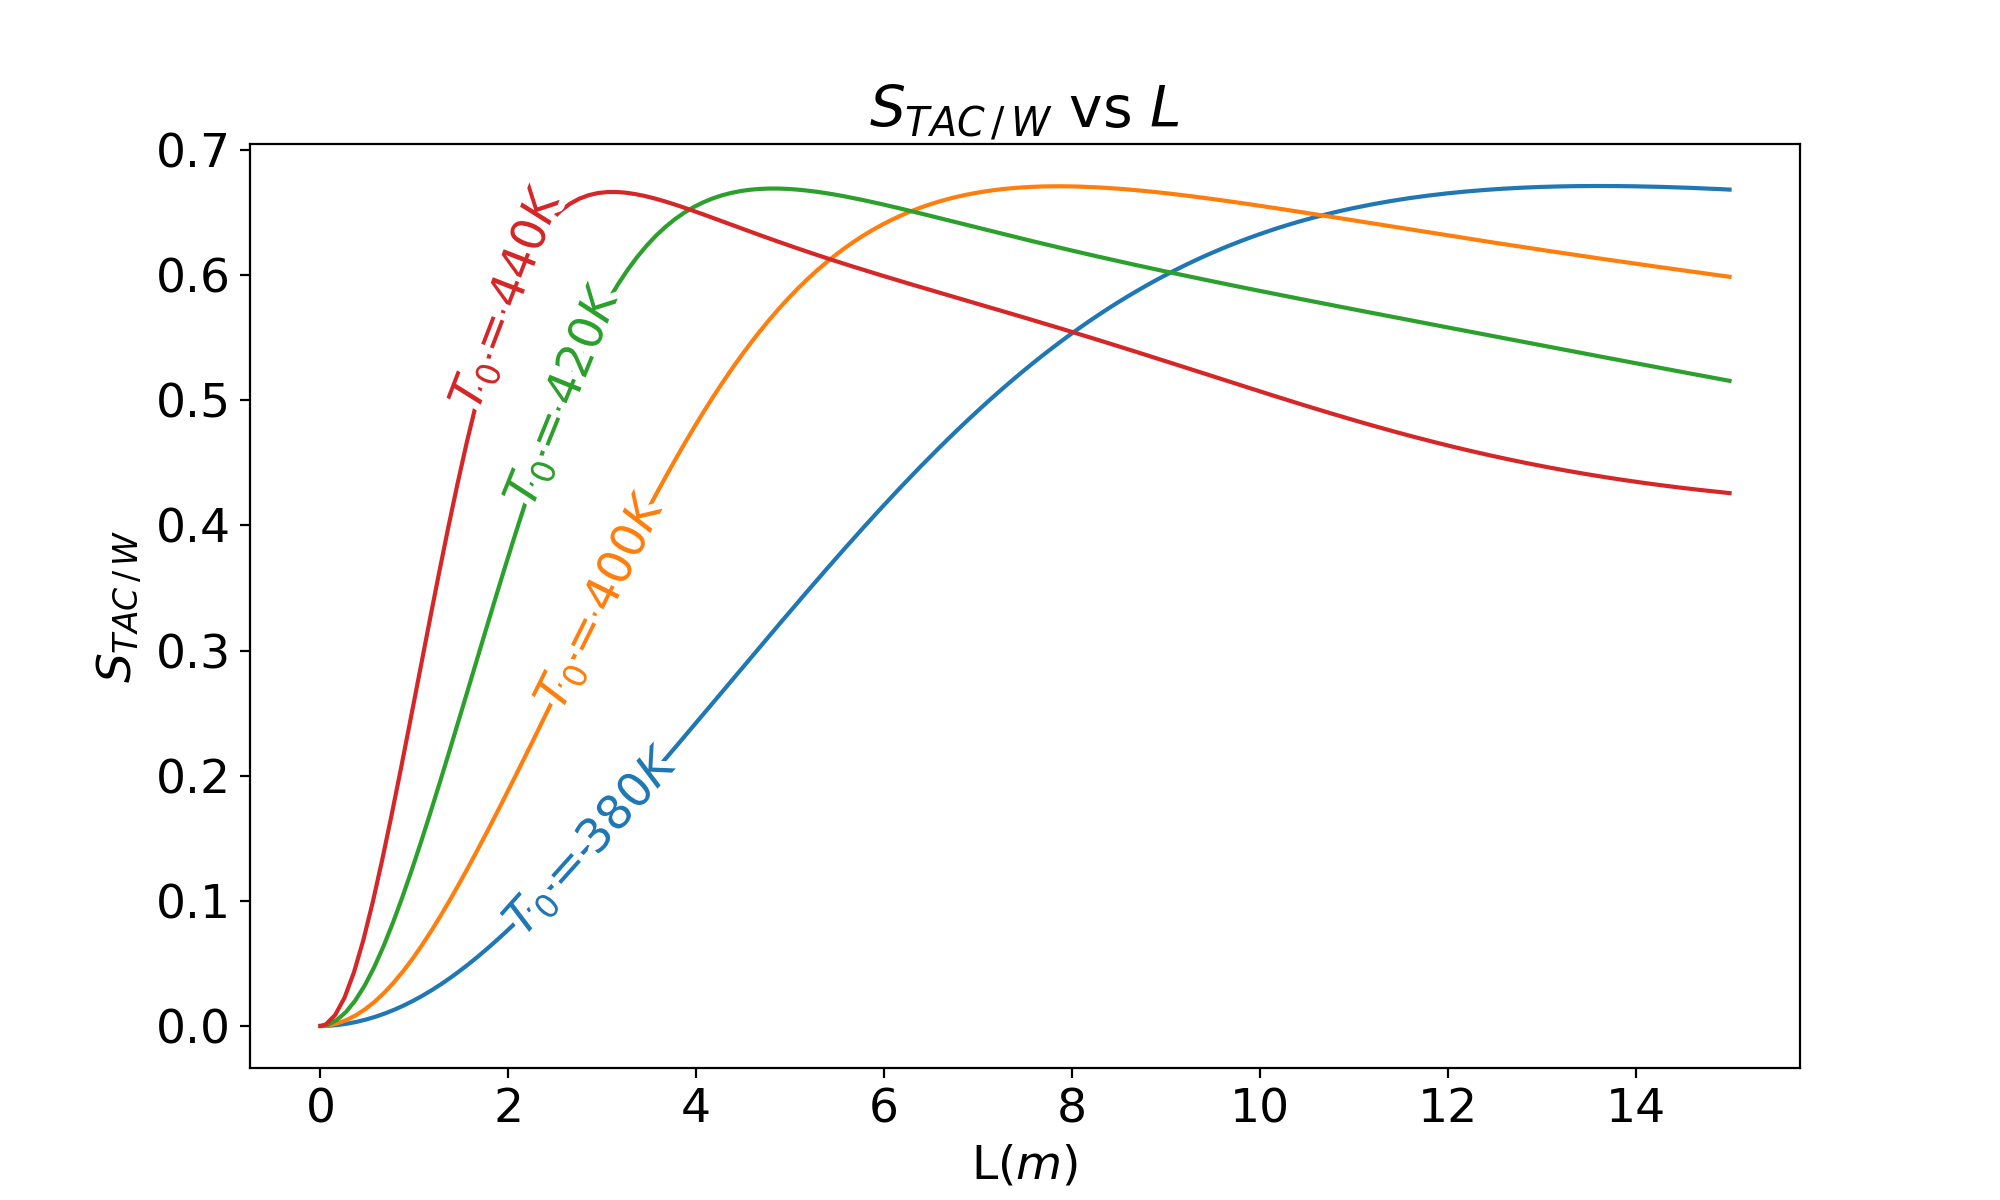

[Text(2.9, 0.1469937184360616, '$T_0=380K$'),
 Text(3.0, 0.33906558210531873, '$T_0=400K$'),
 Text(2.6, 0.5035678446621238, '$T_0=420K$'),
 Text(2.0, 0.5816411538614006, '$T_0=440K$')]

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_W_380 = r380["TAC"] / r380["W"]
s_tac_W_400 = r400["TAC"] / r400["W"]
s_tac_W_420 = r420["TAC"] / r420["W"]
s_tac_W_440 = r440["TAC"] / r440["W"]

ax.set_title("$S_{TAC\,/\,W}$ vs $L$")
ax.set_ylabel("$S_{TAC\,/\,W}$")
ax.set_xlabel("L$(m)$")
s_tac_W_380.plot(ax=ax, legend=False, label="$T_0=380K$")
s_tac_W_400.plot(ax=ax, legend=False, label="$T_0=400K$")
s_tac_W_420.plot(ax=ax, legend=False, label="$T_0=420K$")
s_tac_W_440.plot(ax=ax, legend=False, label="$T_0=440K$")
labelLines(ax.get_lines(), xvals=[2.9, 3.0, 2.6, 2.0], yoffsets=[0, -0.002, -0.002, 0])

In [23]:
def _tac_gly_yield(df):
    return df.iloc[-1]["TAC"] / (df.iloc[0]["GLY"] - df.iloc[-1]["GLY"])

yT = DataFrame(
    [[_tac_gly_yield(F380[F380.index < 9.73]), 
      _tac_gly_yield(F400[F400.index < 9.73]), 
      _tac_gly_yield(F420[F420.index < 9.75]), 
      _tac_gly_yield(F440[F440.index < 9])]], 
    index=["Y TAC/GLY"], 
    columns=[
        "To = 380", 
        "To = 400", 
        "To = 420", 
        "To = 440"]
)

yT

,To = 380,To = 400,To = 420,To = 440
Y TAC/GLY,0.273424,0.384845,0.439035,0.44056


In [24]:
F161, T161, P161, r161 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [25]:
F81, T81, P81, r81 = solve(
    F0=[0.1, 0.8, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [26]:
F41, T41, P41, r41 = solve(
    F0=[0.1, 0.4, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [27]:
F321, T321, P321, r321 = solve(
    F0=[0.1, 3.2, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [28]:
F641, T641, P641, r641 = solve(
    F0=[0.1, 6.4, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=3, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

<IPython.core.display.Javascript object>


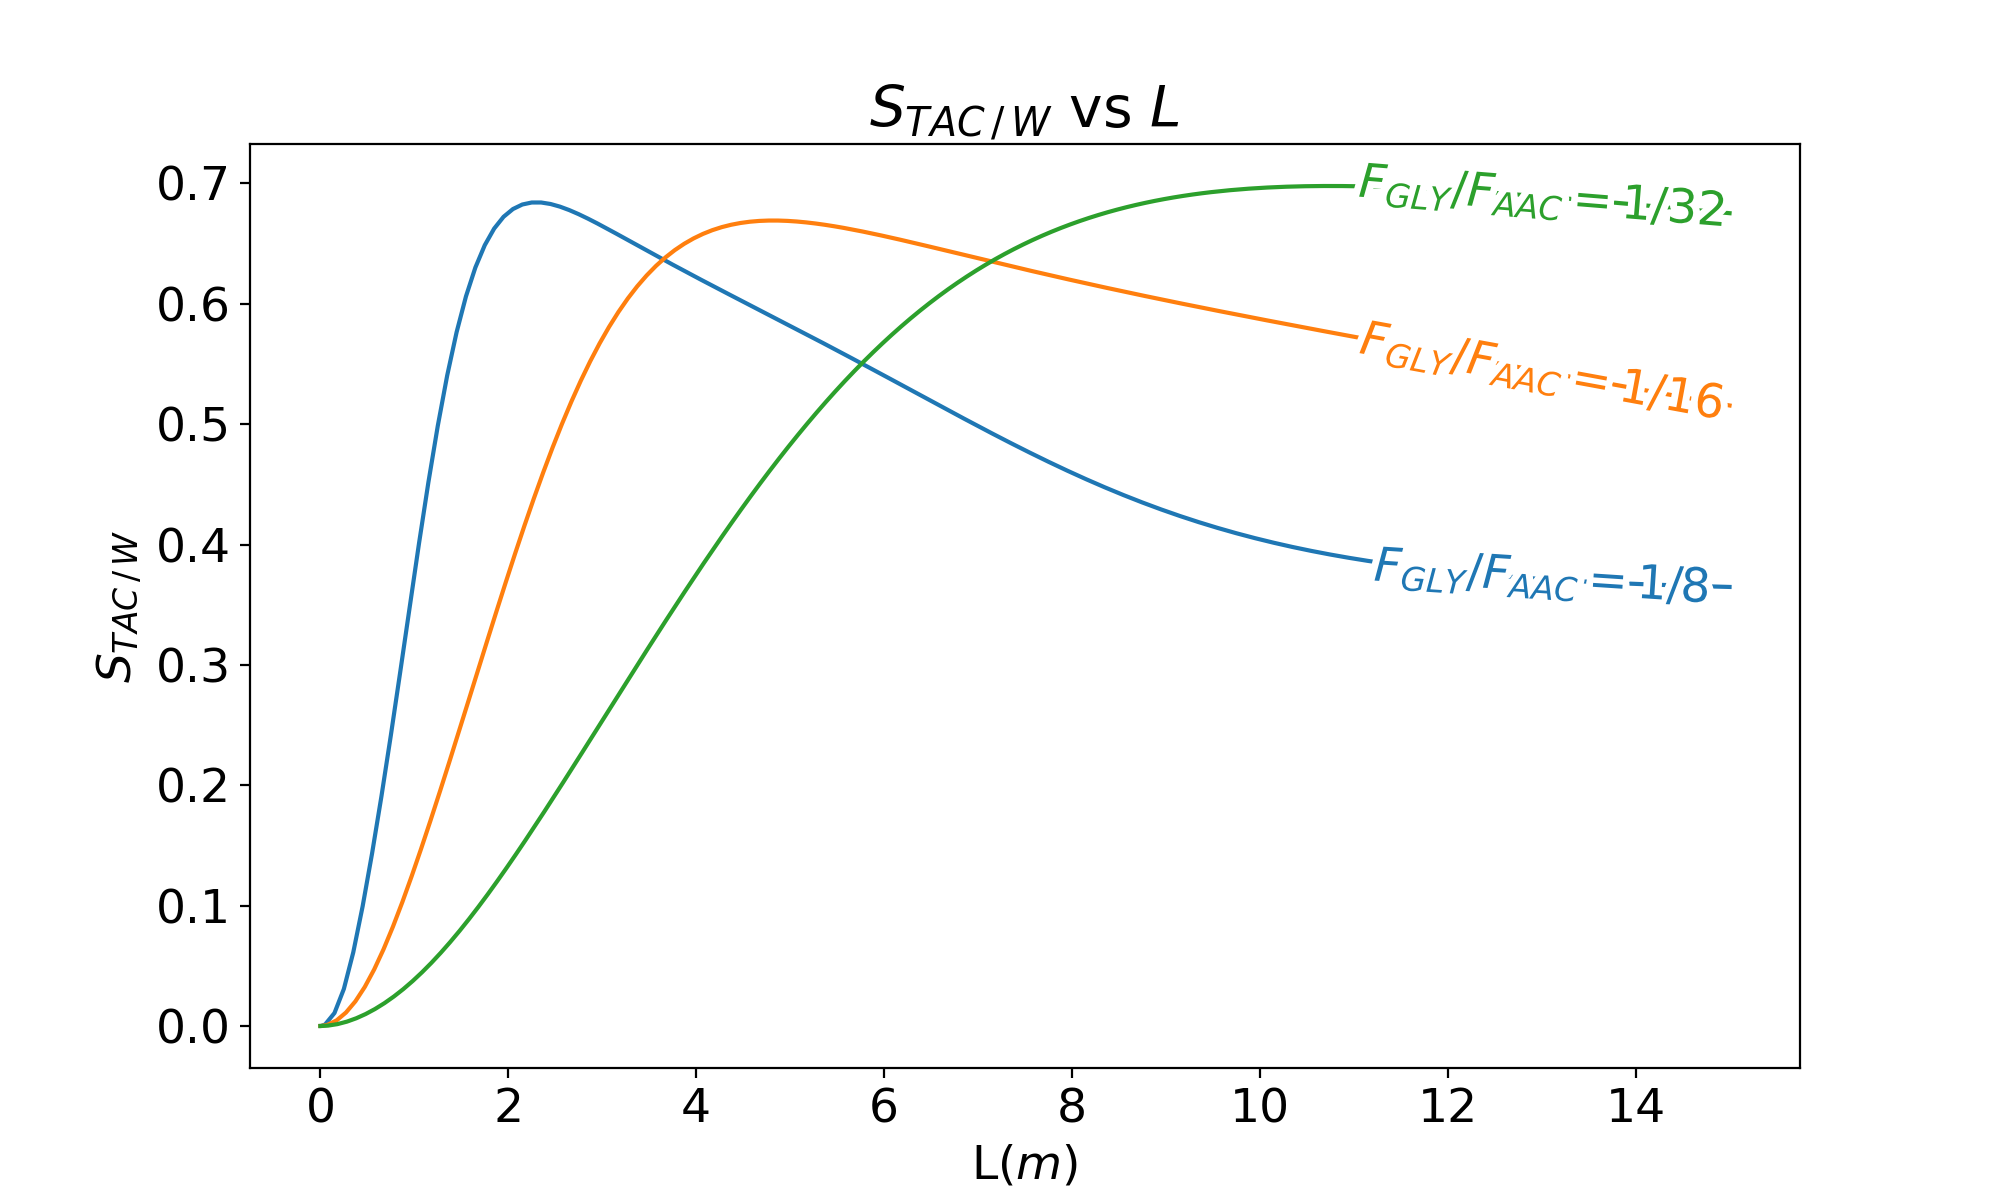

[Text(13.0, 0.3713580306657941, '$F_{GLY}/F_{AAC} = 1/8$'),
 Text(13.0, 0.541858980842565, '$F_{GLY}/F_{AAC} = 1/16$'),
 Text(13.0, 0.6871813828284296, '$F_{GLY}/F_{AAC} = 1/32$')]

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_W_41 = r41["TAC"] / r41["W"]
s_tac_W_81 = r81["TAC"] / r81["W"]
s_tac_W_161 = r161["TAC"] / r161["W"]
s_tac_W_321 = r321["TAC"] / r321["W"]
s_tac_W_641 = r641["TAC"] / r641["W"]

ax.set_title("$S_{TAC\,/\,W}$ vs $L$")
ax.set_ylabel("$S_{TAC\,/\,W}$")
ax.set_xlabel("L$(m)$")
# s_tac_W_41.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/4$")
s_tac_W_81.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/8$")
s_tac_W_161.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/16$")
s_tac_W_321.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/32$")
# s_tac_W_641.plot(ax=ax, legend=False, label="$F_{GLY}/F_{AAC} = 1/64$")
labelLines(ax.get_lines(), xvals=[13, 13, 13], yoffsets=[0, -0.002, -0.002])

In [30]:
yR = DataFrame(
    [[_tac_gly_yield(F41[F41.index < 10]), 
      _tac_gly_yield(F81[F81.index < 10]), 
      _tac_gly_yield(F161[F161.index < 10]),
      _tac_gly_yield(F321[F321.index < 10]),
      # _tac_gly_yield(F641[F641.index < 10])]],
    ]],
    index=["Y TAC/GLY"], 
    columns=[ 
        "F_{GLY}/F_{AAC} = 1/4", 
        "F_{GLY}/F_{AAC} = 1/8", 
        "F_{GLY}/F_{AAC} = 1/16",
        "F_{GLY}/F_{AAC} = 1/32",
        # "F_{GLY}/F_{AAC} = 1/64"]
    ]
)

yR

,F_{GLY}/F_{AAC} = 1/4,F_{GLY}/F_{AAC} = 1/8,F_{GLY}/F_{AAC} = 1/16,F_{GLY}/F_{AAC} = 1/32
Y TAC/GLY,0.263714,0.353196,0.441816,0.423739


In [31]:
F10, T10, P10, r10 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=10, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [32]:
F11, T11, P11, r11 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=11, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

In [33]:
F12, T12, P12, r12 = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0=420, # K
    P0=12, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

<IPython.core.display.Javascript object>


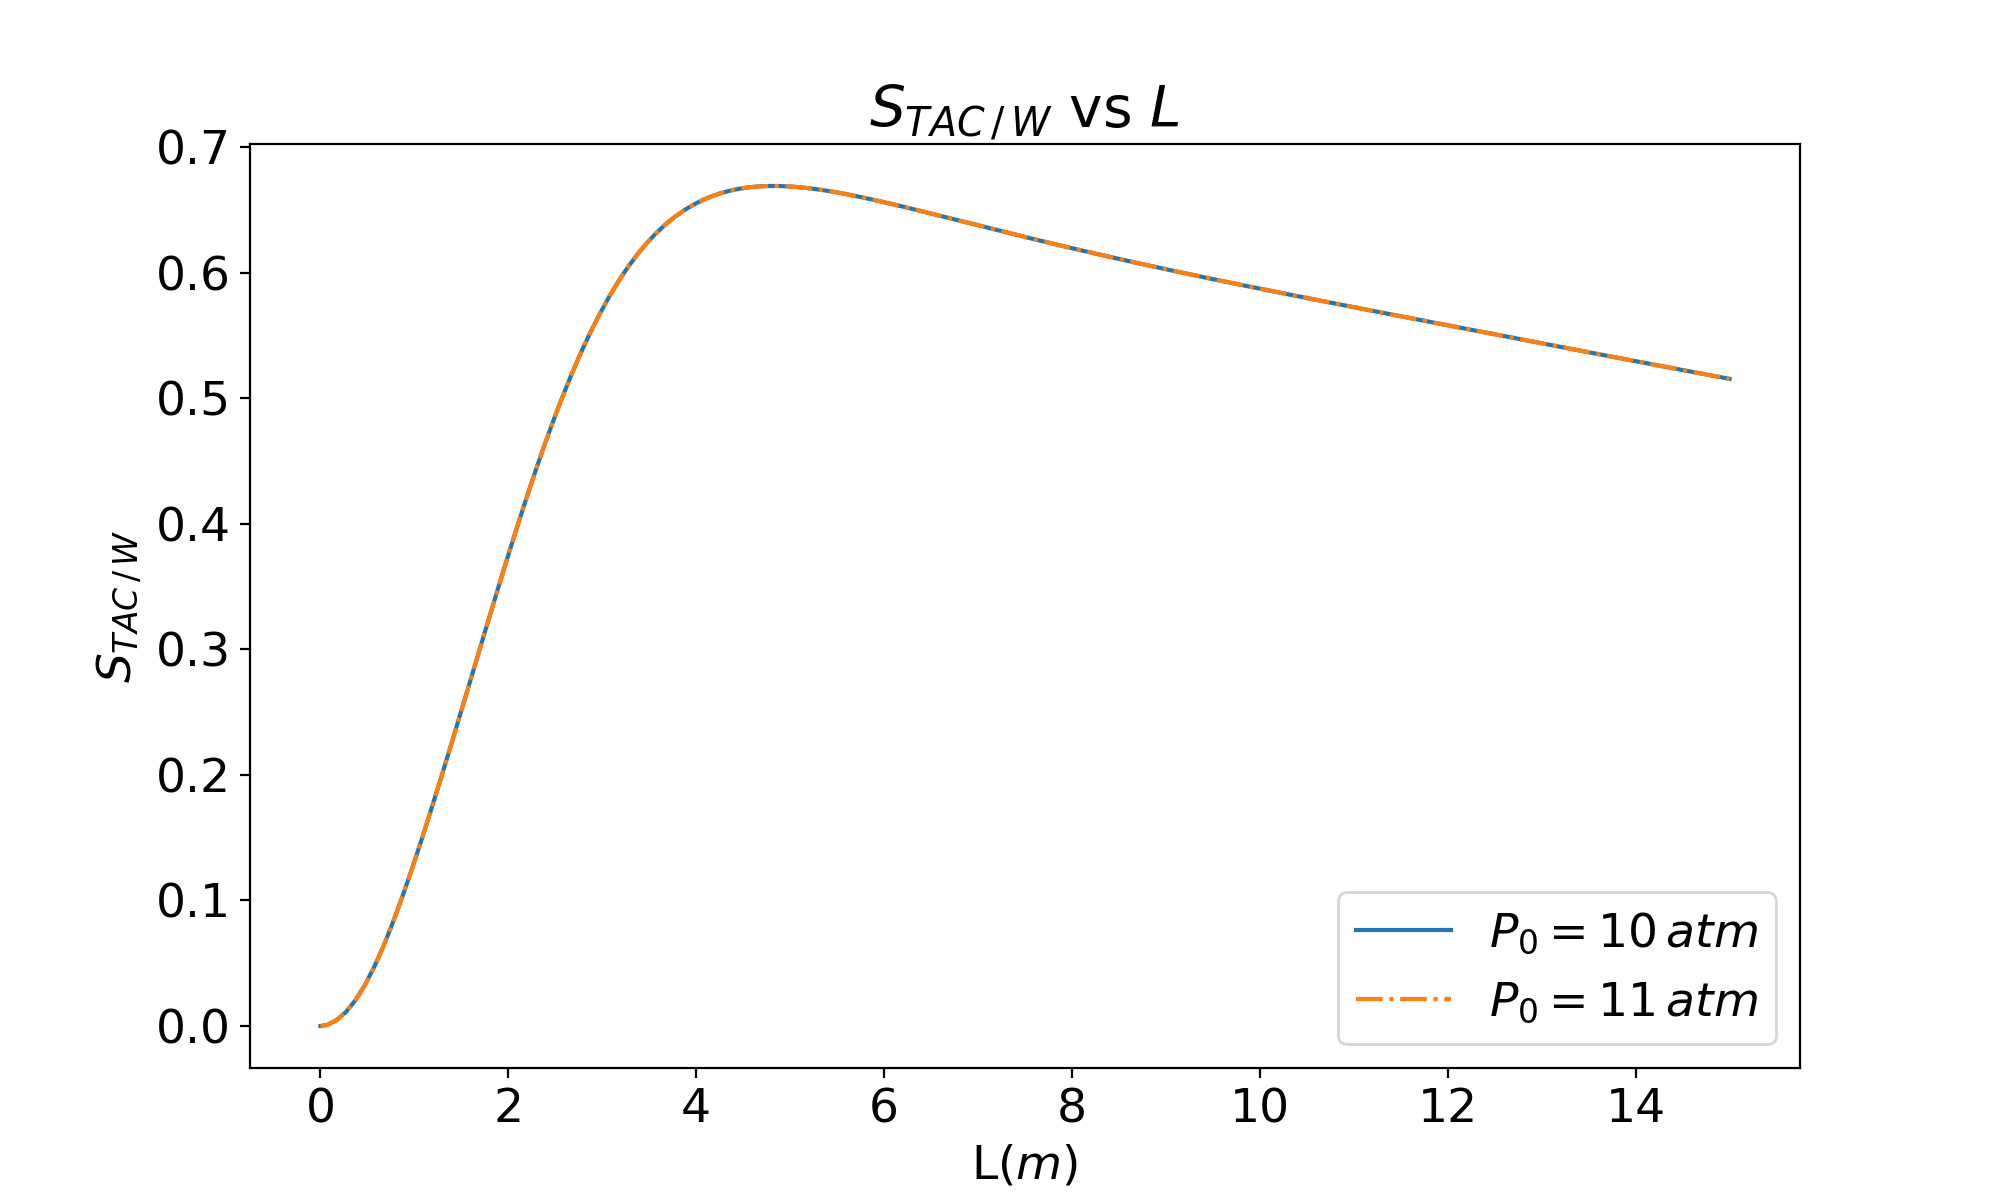

<AxesSubplot: title={'center': '$S_{TAC\\,/\\,W}$ vs $L$'}, xlabel='L$(m)$', ylabel='$S_{TAC\\,/\\,W}$'>

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_W_10 = r10["TAC"] / r10["W"]
s_tac_W_11 = r11["TAC"] / r11["W"]
s_tac_W_12 = r12["TAC"] / r12["W"]

ax.set_title("$S_{TAC\,/\,W}$ vs $L$")
ax.set_ylabel("$S_{TAC\,/\,W}$")
ax.set_xlabel("L$(m)$")
s_tac_W_10.plot(ax=ax, legend=True, label="$P_0 = 10\,atm$", style="-")
s_tac_W_11.plot(ax=ax, legend=True, label="$P_0 = 11\,atm$", style="-.")
# labelLines(ax.get_lines(), xvals=[13, 13, 13], yoffsets=[0, -0.002, -0.002])

In [54]:
F, T, P, r = solve(
    F0=[0.1, 1.6, 0, 0, 0, 0], # mol / L
    T0=420, # K
    P0=10, # atm
    Ta=298.15, # K
    D=1 * 2.54 / 100, # m
    U=22, # W / m2 C
    L=15, # m
    max_step=1
)

<IPython.core.display.Javascript object>


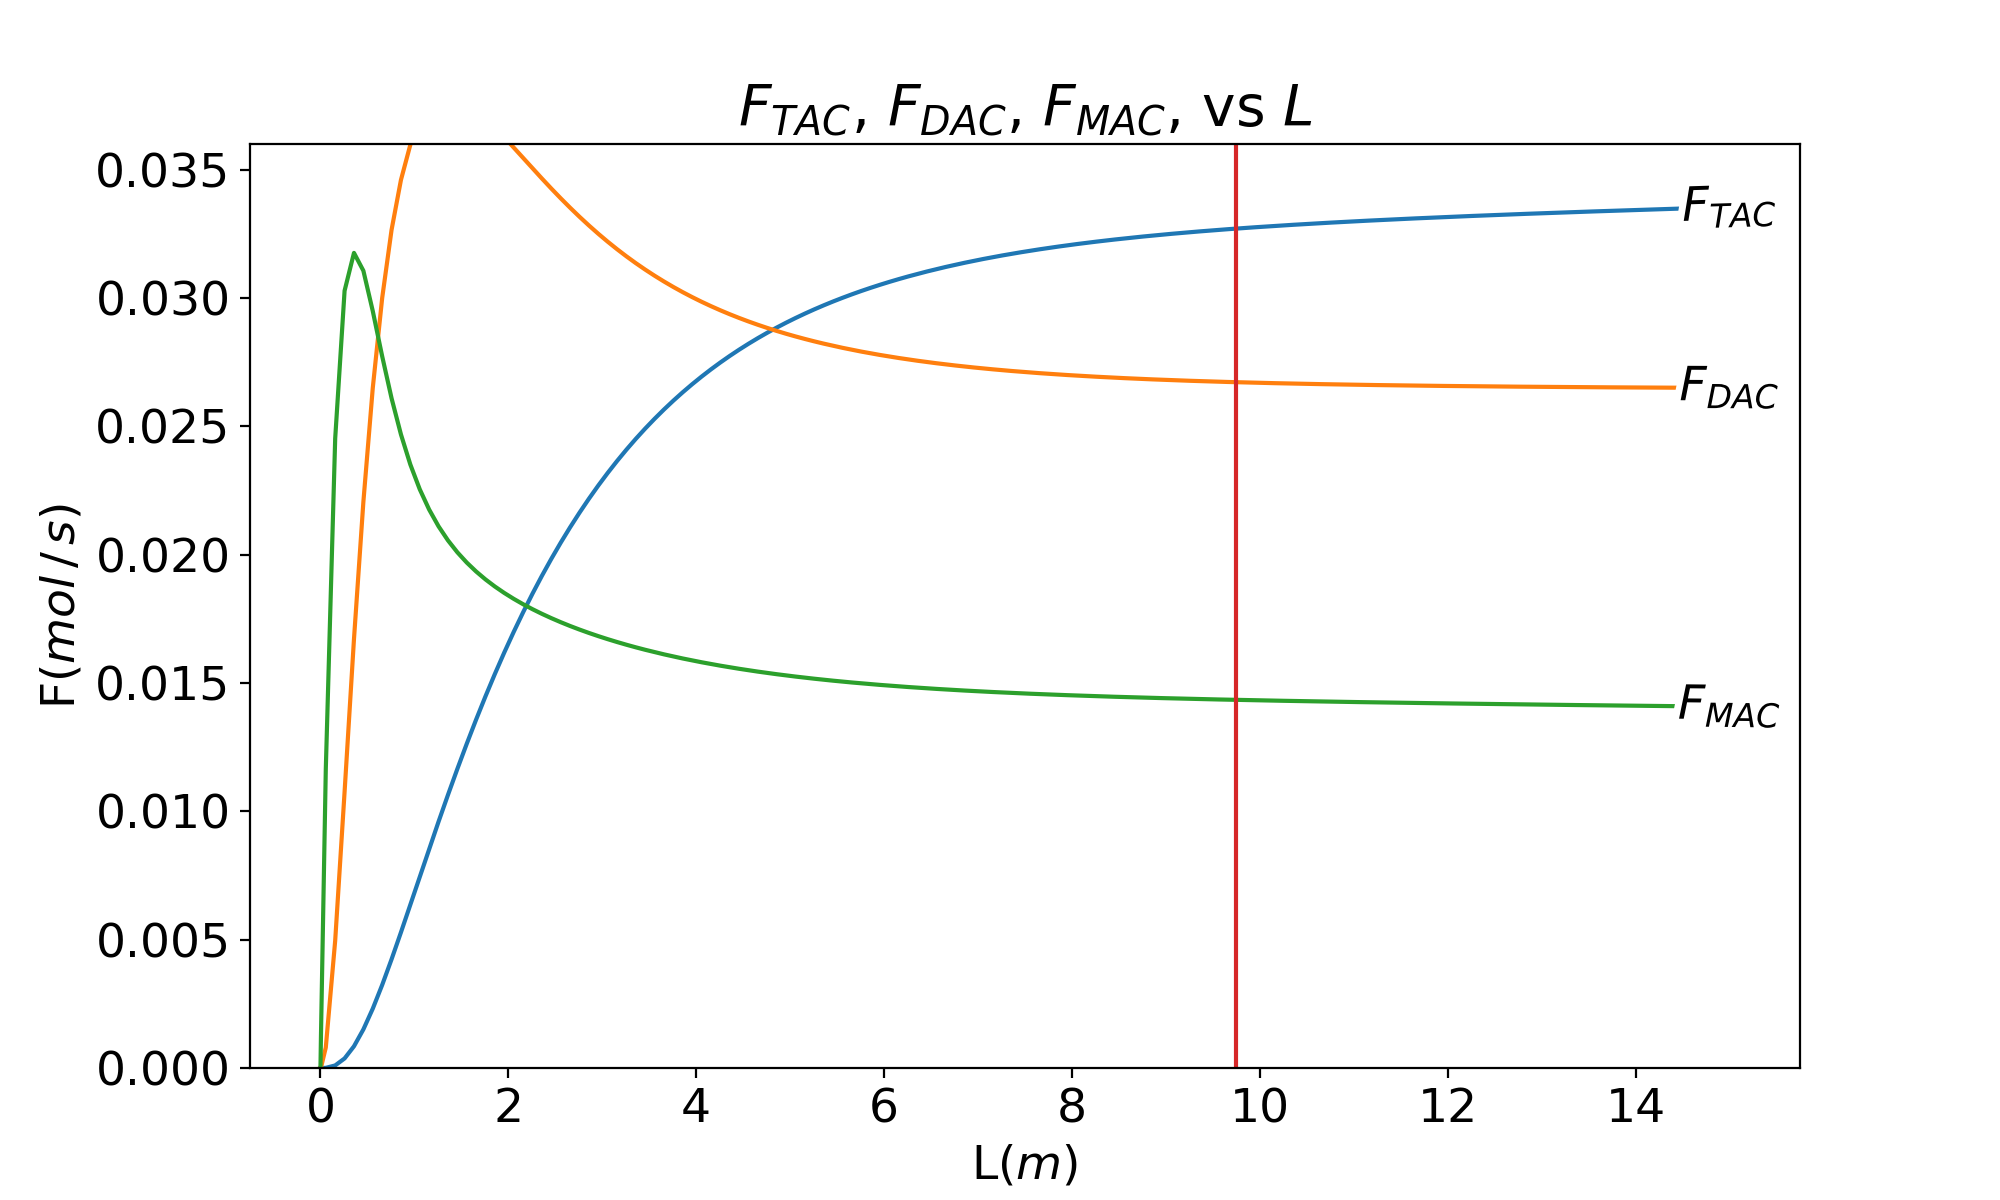

/Users/samsal/code/irq/env/lib/python3.9/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child3), but could not find a label for it.
  warnings.warn(


[Text(15.0, 0.03354325948188548, '$F_{TAC}$'),
 Text(15.0, 0.026494246010486704, '$F_{DAC}$'),
 Text(15.0, 0.01407413065981174, '$F_{MAC}$')]

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

F_of_interest = F440[["TAC", "DAC", "MAC"]]


ax.set_title("$F_{TAC}$, $F_{DAC}$, $F_{MAC}$, vs $L$")
ax.set_ylabel("F$(mol\,/\,s)$")
ax.set_xlabel("L$(m)$")

for column in F_of_interest.columns:
    F_of_interest[column].plot(ax=ax, legend=False, label=f"$F_{{{column}}}$", style="-")     

ax.plot((9.75, 9.75), (0, 0.36))    
ax.set_ylim((0, 0.036))
labelLines(ax.get_lines(), xvals=[15, 15, 15, ], color="k")

<IPython.core.display.Javascript object>


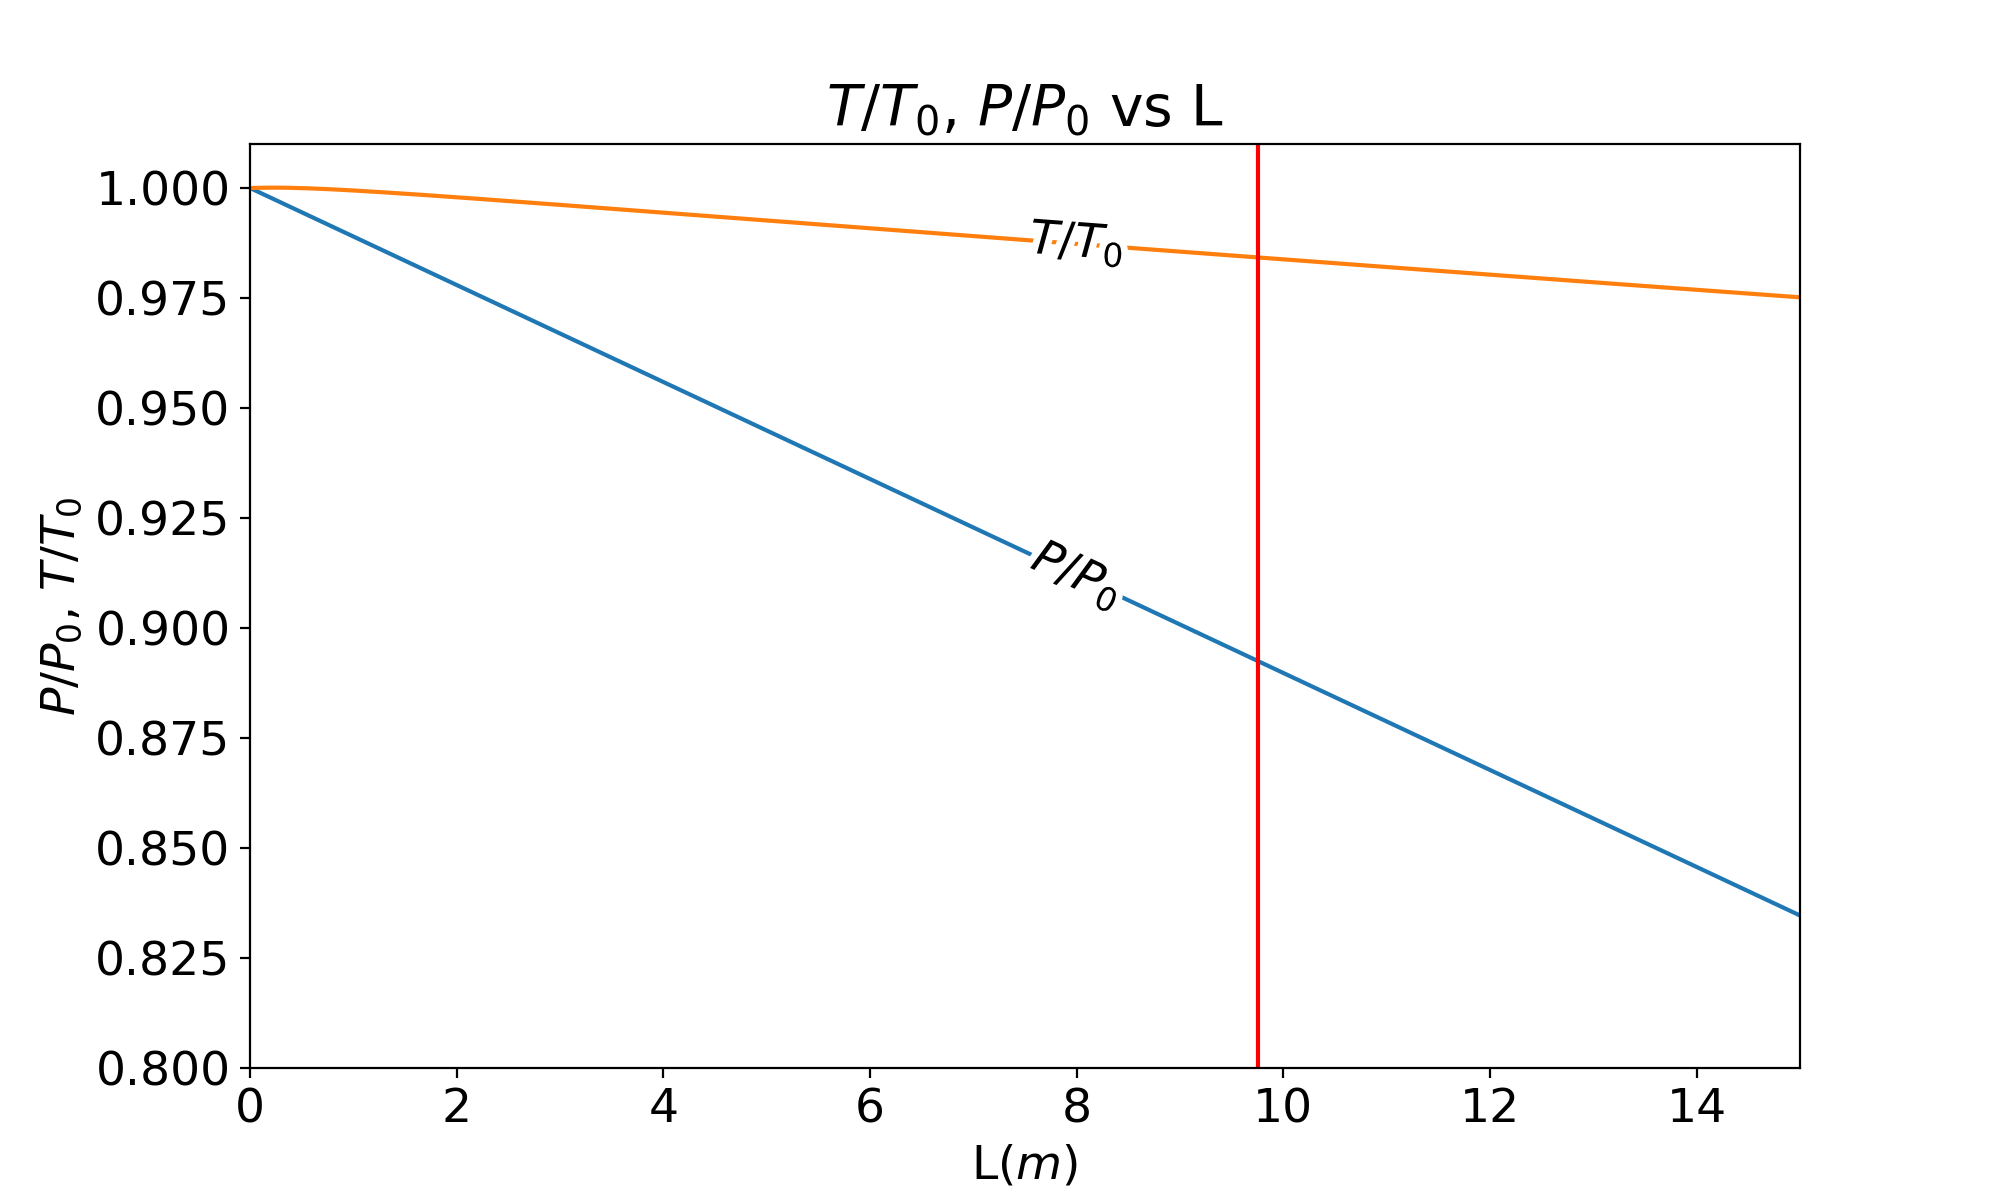

[Text(8.0, 0.9118215275723227, '$P / P_0$'),
 Text(8.0, 0.987295936195854, '$T / T_0$')]

In [69]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.set_ylabel("$P / P_0$, $T / T_0$")
ax.set_xlabel("L$(m)$")

Pnorm = P / P.iloc[0]
Tnorm = T / T.iloc[0]

ax.set_title("$T/T_0$, $P/P_0$ vs L")
Pnorm.plot(ax=ax, legend=False, label="$P / P_0$")
Tnorm.plot(ax=ax, legend=False, label="$T / T_0$")
ax.plot((9.75, 9.75), (0, 1.01), color="r")  
ax.set_ylim((0.8, 1.01))
ax.set_xlim((0, 15))
labelLines(ax.get_lines(), xvals=[8, 8], color="k")

In [38]:
pressure_drop = P.iloc[0] - P.iloc[-1]
pressure_drop

11.022309053459667

In [39]:
temperature_drop = T.iloc[0] - T.iloc[-1]
temperature_drop

106.59569267868142

In [40]:
yearly_production = 10000 * 1000 # kg / y
production = yearly_production * (1 / 365)  * (1 / 24) * (1 / 3600)
production = production * 1000 / substance_data["MW(g/mol)"]["TAC"]
production

1.4532183881115135

In [41]:
production_g = F[F.index <= 10].iloc[-1]["TAC"] * substance_data["MW(g/mol)"]["TAC"]
production_g

2.4244959358263265

In [42]:
n_tubes = production / F[F.index <= 10].iloc[-1]["TAC"]
n_tubes

130.78921484336135

In [43]:
substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
W,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00


In [44]:
_estimate_volumetric_flow([0.1, 1.6, 0, 0, 0, 0])

0.09881684126984128

In [45]:
np.sum(F420.iloc[-1])

1.7

In [46]:
F420.iloc[-1]

GLY    0.024824
AAC    1.427936
W      0.172064
TAC    0.035132
DAC    0.026623
MAC    0.013421
Name: 15.0, dtype: float64

In [47]:
F380.shape[0]

153

In [48]:
F

,GLY,AAC,W,TAC,DAC,MAC
0.000000,0.100000,0.400000,0.000000,0.000000e+00,0.000000,0.000000
0.002887,0.098790,0.398782,0.001218,4.344098e-09,0.000007,0.001203
0.031760,0.087875,0.387092,0.012908,5.164451e-06,0.000772,0.011347
0.103842,0.071095,0.365199,0.034801,1.310578e-04,0.005634,0.023139
0.175924,0.064551,0.352920,0.047080,4.576916e-04,0.010716,0.024275
...,...,...,...,...,...,...
99.642165,0.052997,0.301316,0.098684,1.729474e-02,0.017092,0.012616
99.742165,0.052995,0.301306,0.098694,1.729843e-02,0.017092,0.012615
99.842165,0.052992,0.301295,0.098705,1.730211e-02,0.017092,0.012614
99.942165,0.052989,0.301285,0.098715,1.730579e-02,0.017093,0.012612


In [56]:
F[F.index > 9][F[F.index > 9].index <= 11]

,GLY,AAC,W,TAC,DAC,MAC
9.07182,0.025569,1.433099,0.166901,0.032208,0.028054,0.014170
9.17182,0.025549,1.432945,0.167055,0.032301,0.028003,0.014147
9.27182,0.025530,1.432795,0.167205,0.032390,0.027954,0.014125
9.37182,0.025512,1.432649,0.167351,0.032478,0.027907,0.014104
9.47182,0.025493,1.432506,0.167494,0.032563,0.027861,0.014083
9.57182,0.025475,1.432366,0.167634,0.032646,0.027816,0.014062
9.67182,0.025457,1.432230,0.167770,0.032727,0.027773,0.014043
9.77182,0.025440,1.432097,0.167903,0.032806,0.027732,0.014023
9.87182,0.025423,1.431967,0.168033,0.032882,0.027691,0.014004
9.97182,0.025406,1.431840,0.168160,0.032957,0.027652,0.013986


In [50]:
_arrhenius(200, 43000, 420)

0.0008974384164649665

In [57]:
P[P.index > 9][P[P.index > 9].index <= 11]

9.07182     9.000076
9.17182     8.989054
9.27182     8.978031
9.37182     8.967009
9.47182     8.955987
9.57182     8.944964
9.67182     8.933942
9.77182     8.922920
9.87182     8.911897
9.97182     8.900875
10.07182    8.889853
10.17182    8.878831
10.27182    8.867808
10.37182    8.856786
10.47182    8.845764
10.57182    8.834741
10.67182    8.823719
10.77182    8.812697
10.87182    8.801674
10.97182    8.790652
Name: L(m), dtype: float64

In [58]:
T[T.index > 9][T[T.index > 9].index <= 11]

9.07182     413.871510
9.17182     413.797740
9.27182     413.724004
9.37182     413.650304
9.47182     413.576640
9.57182     413.503011
9.67182     413.429418
9.77182     413.355861
9.87182     413.282341
9.97182     413.208858
10.07182    413.135412
10.17182    413.062003
10.27182    412.988632
10.37182    412.915299
10.47182    412.842004
10.57182    412.768747
10.67182    412.695528
10.77182    412.622349
10.87182    412.549208
10.97182    412.476106
Name: T(K), dtype: float64